In [1]:
# some standard packages
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from random import shuffle

# Importing tf tools
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Activation, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Determine the local directory structure.
os.getcwd()

'/home/ksawczuk/python-repo/InvasiveId'

In [3]:
categories = ['giant hogweed', 'blueweed', 'gorse']

### Data Augmentation
Although I've added a decent number of images to my project, I still consider the dataset to be fairly small for an image classification project.
<br>
Therefore, I've decided to employ the ImageDataGenerator which allows for batches of images to be transformed and augmented in line and fed to the model one at a time.
This will assist with memory management and should allow the maximum amount of info regarding each image to end up in our model.

In [4]:
# Use the Keras ImageDataGenerator for memory efficiency and preprocessing ease
# This process replaces the method of obtaining our data via DataLoader.ipynb
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
)

In [5]:
test_datagen = ImageDataGenerator()

In [6]:
batch_size = 32

In [7]:
train_generator = train_datagen.flow_from_directory(
                                                    'data/final_BC_images/train',
                                                    target_size=(32, 32),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

Found 4862 images belonging to 3 classes.


In [8]:
validation_generator = train_datagen.flow_from_directory(
                                                        'data/final_BC_images/train/',
                                                        target_size=(32, 32,),
                                                        color_mode='rgb',
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        subset='validation'
                                                        )

Found 1215 images belonging to 3 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
                                                  'data/final_BC_images/test/',
                                                  target_size=(32, 32),
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 1632 images belonging to 3 classes.


In [10]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size 

valid_stepsize = validation_generator.samples//validation_generator.batch_size 

test_stepsize = test_generator.samples//test_generator.batch_size 

# Sanity check 
print(f'Training step size = {train_stepsize} \nValidation step size = {valid_stepsize} \nTest step size = {test_stepsize}')

Training step size = 151 
Validation step size = 37 
Test step size = 51


## VGG-16

In [ ]:
# 1.  Import the pretrained VGG16 network, do not include the top layers
pretrained_VGG = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(64, 64, 3))

# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained_VGG.layers:
    layer.trainable=False
    
# Display VGG16 architecture
pretrained_VGG.summary()

In [ ]:
# Instantiate the VGG16 NN model 
weeds_VGG = Sequential()

# Add the pretrained layers 
weeds_VGG.add(pretrained_VGG) 

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
weeds_VGG.add(Dense(256, activation='relu'))
weeds_VGG.add(Dropout(0.5))
weeds_VGG.add(Dense(512, activation='relu'))

# Adding our activation 
weeds_VGG.add(Dense(3, activation='softmax'))

In [ ]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [ ]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
weeds_VGG.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
weeds_VGG.summary()

### VGG16 Training

In [ ]:
# Fitting the model to the training data
history_VGG_2nd = weeds_VGG.fit_generator(generator=train_generator,
                                steps_per_epoch=train_stepsize,
                                epochs=50,
                                validation_data=validation_generator,
                                validation_steps=valid_stepsize,
                                callbacks=[ES])


### VGG16 Results (lr = 0.01)
* Learning Rate set to 0.01
* named 1st for 1st iteration.

In [ ]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_VGG_1st = weeds_VGG.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions_VGG_1st = test_probas_VGG_1st.argmax(axis=1)

In [ ]:
# Getting the true class labels for the test set
test_true_VGG = test_generator.classes

# Sanity check 
test_true_VGG

In [ ]:
# Look at what our model predicted
test_predictions_VGG_1st

In [ ]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_VGG, test_predictions_VGG_1st, target_names=categories))

In [ ]:
# Get a confusion matrix 
test_matrix_VGG_1st = pd.DataFrame(confusion_matrix(test_true_VGG, test_predictions_VGG_1st), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_VGG_1st, cmap='Blues', annot=True, fmt='g')
plt.title('VGG 16: Normalized Confusion Matrix: Test Data(lr=0.01)')
plt.show()

### Loss and Accuracy per Epoch 
learning rate set to 0.01

In [ ]:
plt.figure()
plt.plot(range(0,18,1), history_VGG_1st.history['loss'], label = 'train loss lr:0.01', c = 'b')
plt.plot(range(0,18,1), history_VGG_1st.history['val_loss'], label = 'val loss lr:0.01', c = 'r')
plt.plot(range(0,20,1), history_VGG_2nd.history['loss'], label = 'val loss lr:0.0001', c = 'g')
plt.plot(range(0,20,1), history_VGG_2nd.history['val_loss'], label = 'val loss lr:0.0001', c = 'y')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(range(0,18,1), history_VGG_1st.history['acc'], label = 'train acc lr:0.01', c = 'b')
plt.plot(range(0,18,1), history_VGG_1st.history['val_acc'], label = 'val acc lr:0.01', c = 'r')
plt.plot(range(0,20,1), history_VGG_2nd.history['acc'], label = 'train acc lr:0.0001', c = 'g')
plt.plot(range(0,20,1), history_VGG_2nd.history['val_acc'], label = 'val acc lr:0.0001', c = 'y')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (lr=0.01)')
plt.legend()
plt.show()

### VGG16 Results (lr = 0.0001)
Learning Rate set to 0.0001

In [ ]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_VGG_2nd = weeds_VGG.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions_VGG_2nd = test_probas_VGG_2nd.argmax(axis=1)

In [ ]:
# Look at what our model predicted
test_predictions_VGG_2nd

In [ ]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_VGG, test_predictions_VGG_2nd, target_names=categories))

In [ ]:
# Get a confusion matrix 
test_matrix_VGG_2nd = pd.DataFrame(confusion_matrix(test_true_VGG, test_predictions_VGG_2nd), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_VGG_2nd, cmap='Blues', annot=True, fmt='g')
plt.title('VGG 16: Normalized Confusion Matrix: Test Data')
plt.show()

### Loss and Accuracy per Epoch 
learning rate set to 0.0001

In [ ]:
plt.figure()
plt.plot(range(0,20,1), history_VGG_2nd.history['loss'], label = 'train loss', c = 'b')
plt.plot(range(0,20,1), history_VGG_2nd.history['val_loss'], label = 'val loss', c = 'r')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (lr=0.0001)')
plt.legend()
plt.show() 

In [ ]:
plt.figure()
plt.plot(range(0,20,1), history_VGG_2nd.history['acc'], label = 'train acc', c = 'b')
plt.plot(range(0,20,1), history_VGG_2nd.history['val_acc'], label = 'val acc', c = 'r')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (lr=0.0001)')
plt.legend()
plt.show()

# New Model

## VGG-16 New

In [11]:
# 1.  Import the pretrained VGG16 network, do not include the top layers
pretrained_VGG = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(32, 32, 3))

# 2.  Setting all layers to not trainable so weights wont be tweaked
for layer in pretrained_VGG.layers:
    layer.trainable=False
    
# Display VGG16 architecture
pretrained_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [12]:
# Instantiate the VGG16 NN model 
VGG = Sequential()

# Add the pretrained layers 
VGG.add(pretrained_VGG) 

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
# 1st perform batch normalizaiton:

VGG.add(Dense(256, activation='relu'))
VGG.add(BatchNormalization())
VGG.add(Dense(512, activation='relu'))
VGG.add(Dropout(0.5))
VGG.add(Dense(256, activation='relu'))

# Adding our activation 
VGG.add(Dense(3, activation='softmax'))

In [13]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_loss', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [14]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
VGG.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
VGG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 7

### VGG16 Training

In [15]:
# Fitting the model to the training data
history_VGG = VGG.fit_generator(generator=train_generator,
                        steps_per_epoch=train_stepsize,
                        epochs=50,
                        validation_data=validation_generator,
                        validation_steps=valid_stepsize,
                        callbacks=[ES])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
151/151 [==============================] - 93s 616ms/step - loss: 0.7413 - acc: 0.6889 - val_loss: 0.5138 - val_acc: 0.7981
Epoch 2/50
151/151 [==============================] - 98s 652ms/step - loss: 0.5476 - acc: 0.7843 - val_loss: 0.4804 - val_acc: 0.8201
Epoch 3/50
151/151 [==============================] - 99s 655ms/step - loss: 0.4990 - acc: 0.8068 - val_loss: 0.4366 - val_acc: 0.8285
Epoch 4/50
151/151 [==============================] - 99s 656ms/step - loss: 0.4770 - acc: 0.8128 - val_loss: 0.4325 - val_acc: 0.8395
Epoch 5/50
151/151 [==============================] - 98s 651ms/step - loss: 0.4623 - acc: 0.8188 - val_loss: 0.4213 - val_acc: 0.8328
Epoch 6/50
151/151 [==============================] - 99s 654ms/step - loss: 0.4457 - acc: 0.8273 - val_loss: 0.4168 - val_acc: 0.8480
Epoch 7/50
151/151 [==============================] - 99s 653ms/step - loss: 0.4452 - acc: 0.8315 - val_loss: 0.39

### Fine Tuning
Unfreeze all the layers of the pretrained model, recompile without rebuilding to ensure normalization values aren't lost.<br>
Retrain on the data to provide better results.

In [16]:
VGG.layers

In [17]:
pretrained_VGG.trainable = True

In [18]:
# Istantiating Adam again optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.00001) 

# Compiling the CNN model 
VGG.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
VGG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 7

In [19]:
# Fitting the model to the training data
history_VGG_fine_tune = VGG.fit_generator(generator=train_generator,
                        steps_per_epoch=train_stepsize,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=valid_stepsize,
                        callbacks=[ES])


Epoch 1/10
151/151 [==============================] - 333s 2s/step - loss: 0.3436 - acc: 0.8696 - val_loss: 0.3265 - val_acc: 0.8834
Epoch 2/10
151/151 [==============================] - 344s 2s/step - loss: 0.2912 - acc: 0.8919 - val_loss: 0.3331 - val_acc: 0.8801
Epoch 3/10
151/151 [==============================] - 348s 2s/step - loss: 0.3000 - acc: 0.8896 - val_loss: 0.2796 - val_acc: 0.8894
Epoch 4/10
151/151 [==============================] - 351s 2s/step - loss: 0.2634 - acc: 0.9002 - val_loss: 0.2888 - val_acc: 0.8953
Epoch 5/10
151/151 [==============================] - 349s 2s/step - loss: 0.2519 - acc: 0.9081 - val_loss: 0.2800 - val_acc: 0.9029
Epoch 6/10
151/151 [==============================] - 348s 2s/step - loss: 0.2490 - acc: 0.9068 - val_loss: 0.2501 - val_acc: 0.9071
Epoch 7/10
151/151 [==============================] - 350s 2s/step - loss: 0.2765 - acc: 0.9000 - val_loss: 0.2646 - val_acc: 0.8995
Epoch 8/10
151/151 [==============================] - 350s 2s/step - 

### VGG16 Fine Tuned
Learning Rate set to 0.00001

In [22]:
# Getting bestmodel's predictions (as probabilities) on the test set 
test_probas_model = VGG.predict_generator(test_generator, steps=test_stepsize)

# Setting the model's class prediction as the class that received the highest probability for each image
test_predictions = test_probas_model.argmax(axis=1)

In [23]:
# Look at what our model predicted
test_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
# Getting the true class labels for the test set
test_true_VGG = test_generator.classes

# Sanity check 
test_true_VGG

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [26]:
# Displaying the classification report for the test set
print('Classification Report\n \n', classification_report(test_true_VGG, test_predictions, target_names=categories))

Classification Report
 
                precision    recall  f1-score   support

giant hogweed       0.80      0.89      0.84       506
     blueweed       0.89      0.87      0.88       523
        gorse       0.92      0.85      0.88       603

     accuracy                           0.87      1632
    macro avg       0.87      0.87      0.87      1632
 weighted avg       0.87      0.87      0.87      1632



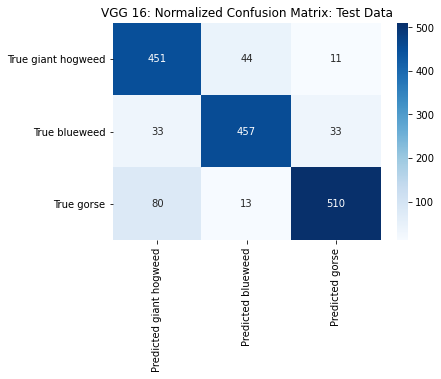

In [30]:
# Get a confusion matrix 
test_matrix_VGG = pd.DataFrame(confusion_matrix(test_true_VGG, test_predictions), 
                           columns=['Predicted ' + cat_name for cat_name in categories], 
                           index=['True ' + cat_name for cat_name in categories])

# Plotting as a heatmap 
plt.figure()
sns.heatmap(test_matrix_VGG, cmap='Blues', annot=True, fmt='g')
plt.title('VGG 16: Normalized Confusion Matrix: Test Data')
plt.show()

### Loss and Accuracy per Epoch 
learning rate set to 0.0001

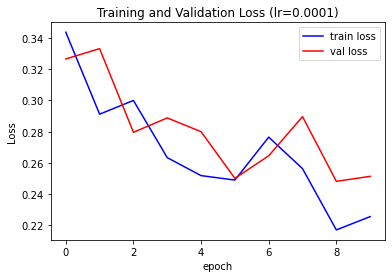

In [31]:
plt.figure()
plt.plot(range(0,10,1), history_VGG_fine_tune.history['loss'], label = 'train loss', c = 'b')
plt.plot(range(0,10,1), history_VGG_fine_tune.history['val_loss'], label = 'val loss', c = 'r')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (lr=0.0001)')
plt.legend()
plt.show() 

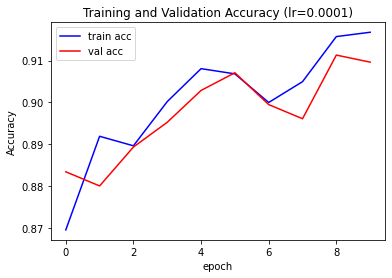

In [33]:
plt.figure()
plt.plot(range(0,10,1), history_VGG_fine_tune.history['acc'], label = 'train acc', c = 'b')
plt.plot(range(0,10,1), history_VGG_fine_tune.history['val_acc'], label = 'val acc', c = 'r')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (lr=0.0001)')
plt.legend()
plt.show()